# 导入库

In [2]:
#import warnings
#warnings.filterwarnings("ignore")

In [3]:
import time
import MeCab
import glob
import pandas as pd
import numpy as np
import re
import csv
#from xlwt import Workbook
#import urllib.request

# gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim

# pyplot
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Text Data Cleaning

In [4]:
time_2019 = []
for i in range(10, 22):
    time = "2019-09-{}".format(i)
    time_2019.append(time)
time_2020 = []
for i in range(15, 29):
    time = "2020-10-{}".format(i)
    time_2020.append(time)
time_2021 = []
for i in range(6, 13):
    time = "2021-04-{}".format(i)
    if len(time.split("-")[-1]) == 1:
        time = "2021-04-0{}".format(i)
    time_2021.append(time)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
time_all = time_2019 + time_2020 + time_2021
#time_all

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## udf_study_pub_type -> 用于分析的非认证用户数据(40287条 -> 38003条)

In [6]:
#udf_study = df_study.query('user_verified == False')
udf_under10 = pd.read_csv("udf_under10.csv")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
udf_study = udf_under10.query('date in @time_all')
udf_study.reset_index(drop = True, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
udf_study_pub_type = udf_study
udf_study_pub_type[["media", "political elite", "other", "public"]] = ["0", "0", "0", "1"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-1699d415f6cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  udf_study_pub_type[["media", "political elite", "other", "public"]] = ["0", "0", "0", "1"]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [9]:
udf_study_other_type = pd.read_csv("udf_study_other_type.csv")
udf_study_other_type["public"] = "0"

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
vdf_study_type = pd.read_csv("vdf_study_type.csv")
vdf_study_type["public"] = "0"

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## df_sam -> udf_study_pub_type + udf_study_other_type + vdf_study_type

In [11]:
df_sam_all = udf_study_pub_type.append(udf_study_other_type).append(vdf_study_type)
df_sam_all.reset_index(drop = True, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
df_sam = df_sam_all.query('date in @time_2019')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df_sam[df_sam["public"] == "0"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,created_at,date,month,user_id_str,user_name,user_full_name,full_text,user_verified,urls,retweet_count,favorite_count,media,political elite,other,public
38003,2019-09-10T01:24:44+00:00,2019-09-10,2019-09,144812834,karrento,tsuto,知り合いの外人が、『日本を経営する一番偉い人が、放射能、汚染水は問題ないです！と言って、問題...,False,NaN,1,3,0,0,1,0
38004,2019-09-10T01:39:01+00:00,2019-09-10,2019-09,70244743,hideinu,和田秀子,福島原発「汚染水を海に放出」経産省説明会に地元漁師の怒り\nhttps://t.co/5mf...,False,https://t.co/5mf4ijtFzw,16,13,0,0,1,0
38005,2019-09-10T03:07:04+00:00,2019-09-10,2019-09,10462562,47news,47NEWS,原発処理水「放出しかない」 環境相が発言 https://t.co/czqsXbbbbq,False,https://t.co/czqsXbbbbq,62,34,0,0,1,0
38006,2019-09-10T03:17:30+00:00,2019-09-10,2019-09,2383663554,shiratama_ji,天瀬ひみか【公式】予言コード解説サポート,原発処理水「放出しかない」 環境相が発言\n\n東京電力福島第1原発で増え続ける汚染水を浄化...,False,https://t.co/qqsUUQSr9h,24,7,0,0,1,0
38007,2019-09-10T03:19:07+00:00,2019-09-10,2019-09,2383663554,shiratama_ji,天瀬ひみか【公式】予言コード解説サポート,海に「放出しかない」＝福島第1の汚染水処理－原田環境相\n\n原田義昭環境相は10日の閣議後...,False,https://t.co/2Jd4OKdd74,46,15,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40560,2019-09-21T03:42:07+00:00,2019-09-21,2019-09,126533936,yanagase_ootaku,やながせ裕文 (参議院議員),放出するのは、あくまで法で定められた濃度以下の処理水。現在保管されている水をそのまま流すので...,True,https://t.co/Fje3nGa327,113,271,0,1,0,0
40561,2019-09-21T07:29:22+00:00,2019-09-21,2019-09,112551613,SatoMasahisa,佐藤正久,文政権が“嫌がらせ”展開か「放射能五輪は危険」 原発処理水に難くせも…韓国はすでに「日本の６...,True,https://t.co/RMQlX2NofL,5379,14649,0,1,0,0
40562,2019-09-21T07:59:01+00:00,2019-09-21,2019-09,68643433,zakdesk,zakzak,【大前研一のニュース時評】進次郎氏の“無責任”発言は議論を遅らせる 原発処理水の「海洋放出」...,True,https://t.co/em6ytGgSxJ,17,27,1,0,0,0
40563,2019-09-21T11:02:10+00:00,2019-09-21,2019-09,624214070,JCC_NEWS,JCC株式会社,09/21 08:44 日テレ ウェークアップ！ぷらす 韓国ＩＡＥＡに現地調査要請・小泉環境...,True,https://t.co/loNbz6ULaQ,0,1,0,0,1,0


In [58]:
#for i, d in df_sam.query('date == "2019-09-10"').iterrows():
    #print(i, "\n", d.full_text)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 统计各阶段各类型账号数量

In [15]:
print("————第1阶段：2019年9月————")
df_sam1 = df_sam[df_sam.month == "2019-09"]
num_tweets = df_sam1.shape[0]
num_users = df_sam1.user_id_str.unique().shape[0]

# 为什么有的1要加引号，有的1不用？？
pub_num_tweets = df_sam1[df_sam1.public == "1"].shape[0]
pub_num_users = df_sam1[df_sam1.public == "1"].user_id_str.unique().shape[0]

media_num_tweets = df_sam1[df_sam1.media == 1].shape[0]
media_num_users = df_sam1[df_sam1.media == 1].user_id_str.unique().shape[0]

political_num_tweets = df_sam1[df_sam1["political elite"] == 1].shape[0]
political_num_users = df_sam1[df_sam1["political elite"] == 1].user_id_str.unique().shape[0]

other_num_tweets = df_sam1[df_sam1.other == 1].shape[0]
other_num_users = df_sam1[df_sam1.other == 1].user_id_str.unique().shape[0]
print("\n————总计————")
print("推文数：%d\n独立用户数：%d\n" % (num_tweets, num_users))
print("————媒体————")
print("推文数：%d\n独立用户数：%d\n" % (media_num_tweets, media_num_users))
print("————政治精英————")
print("推文数：%d\n独立用户数：%d\n" % (political_num_tweets, political_num_users))
print("————自媒体————")
print("推文数：%d\n独立用户数：%d\n" % (other_num_tweets, other_num_users))
print("————公众————")
print("推文数：%d\n独立用户数：%d\n" % (pub_num_tweets, pub_num_users))

print("\n————第2阶段：2020年10月————")
df_sam1 = df_sam[df_sam.month == "2020-10"]
num_tweets = df_sam1.shape[0]
num_users = df_sam1.user_id_str.unique().shape[0]

# 为什么有的1要加引号，有的1不用？？
pub_num_tweets = df_sam1[df_sam1.public == "1"].shape[0]
pub_num_users = df_sam1[df_sam1.public == "1"].user_id_str.unique().shape[0]

media_num_tweets = df_sam1[df_sam1.media == 1].shape[0]
media_num_users = df_sam1[df_sam1.media == 1].user_id_str.unique().shape[0]

political_num_tweets = df_sam1[df_sam1["political elite"] == 1].shape[0]
political_num_users = df_sam1[df_sam1["political elite"] == 1].user_id_str.unique().shape[0]

other_num_tweets = df_sam1[df_sam1.other == 1].shape[0]
other_num_users = df_sam1[df_sam1.other == 1].user_id_str.unique().shape[0]
print("\n————总计————")
print("推文数：%d\n独立用户数：%d\n" % (num_tweets, num_users))
print("————媒体————")
print("推文数：%d\n独立用户数：%d\n" % (media_num_tweets, media_num_users))
print("————政治精英————")
print("推文数：%d\n独立用户数：%d\n" % (political_num_tweets, political_num_users))
print("————自媒体————")
print("推文数：%d\n独立用户数：%d\n" % (other_num_tweets, other_num_users))
print("————公众————")
print("推文数：%d\n独立用户数：%d\n" % (pub_num_tweets, pub_num_users))

print("\n————第3阶段：2021年4月————")
df_sam1 = df_sam[df_sam.month == "2021-04"]
num_tweets = df_sam1.shape[0]
num_users = df_sam1.user_id_str.unique().shape[0]

# 为什么有的1要加引号，有的1不用？？
pub_num_tweets = df_sam1[df_sam1.public == "1"].shape[0]
pub_num_users = df_sam1[df_sam1.public == "1"].user_id_str.unique().shape[0]

media_num_tweets = df_sam1[df_sam1.media == 1].shape[0]
media_num_users = df_sam1[df_sam1.media == 1].user_id_str.unique().shape[0]

political_num_tweets = df_sam1[df_sam1["political elite"] == 1].shape[0]
political_num_users = df_sam1[df_sam1["political elite"] == 1].user_id_str.unique().shape[0]

other_num_tweets = df_sam1[df_sam1.other == 1].shape[0]
other_num_users = df_sam1[df_sam1.other == 1].user_id_str.unique().shape[0]
print("\n————总计————")
print("推文数：%d\n独立用户数：%d\n" % (num_tweets, num_users))
print("————媒体————")
print("推文数：%d\n独立用户数：%d\n" % (media_num_tweets, media_num_users))
print("————政治精英————")
print("推文数：%d\n独立用户数：%d\n" % (political_num_tweets, political_num_users))
print("————自媒体————")
print("推文数：%d\n独立用户数：%d\n" % (other_num_tweets, other_num_users))
print("————公众————")
print("推文数：%d\n独立用户数：%d\n" % (pub_num_tweets, pub_num_users))

print("\n————3阶段合计————")
num_tweets = df_sam.shape[0]
num_users = df_sam.user_id_str.unique().shape[0]
print("总推文数：%d\n总独立用户数：%d\n" % (num_tweets, num_users))

————第1阶段：2019年9月————

————总计————
推文数：13925
独立用户数：10186

————媒体————
推文数：152
独立用户数：64

————政治精英————
推文数：58
独立用户数：22

————自媒体————
推文数：781
独立用户数：166

————公众————
推文数：12933
独立用户数：9933


————第2阶段：2020年10月————

————总计————
推文数：0
独立用户数：0

————媒体————
推文数：0
独立用户数：0

————政治精英————
推文数：0
独立用户数：0

————自媒体————
推文数：0
独立用户数：0

————公众————
推文数：0
独立用户数：0


————第3阶段：2021年4月————

————总计————
推文数：0
独立用户数：0

————媒体————
推文数：0
独立用户数：0

————政治精英————
推文数：0
独立用户数：0

————自媒体————
推文数：0
独立用户数：0

————公众————
推文数：0
独立用户数：0


————3阶段合计————
总推文数：13925
总独立用户数：10186



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### data_sam -> df_sam中的文本数据

In [16]:
#data_d_sam => data_dict_samの略称
#data_d_sam = {}
#for i, d in df_sam.iterrows():
   # if d.user_id_str not in data_d_sam.keys():
     #   data_d_sam[d.user_id_str] = [d.full_text]
  #  else:
   #     data_d_sam[d.user_id_str].append(d.full_text)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#data_sam = ['\n'.join(thread) for thread in data_d_sam.values()]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
#data_sam = []
#user_id_str = []
#for i, d in data_d_sam.items():
 #   thread = '\n'.join(d)
  #  data_sam.append(thread)
  #  user_id_str.append(i)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df_sam.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,created_at,date,month,user_id_str,user_name,user_full_name,full_text,user_verified,urls,retweet_count,favorite_count,media,political elite,other,public
0,2019-09-10T01:15:27+00:00,2019-09-10,2019-09,1168352626754195456,eDzcZV5g6ctldT1,kouichi☆新アカウント🇯🇵🗾🎌,@daitojimari @agora_japan 韓国は最後までゴミの海洋投棄をしていた国...,False,NaN,0,2,0,0,0,1
1,2019-09-10T01:57:10+00:00,2019-09-10,2019-09,548389275,tajigennorihiro,範弘,引用&gt;「地球上には原発を運営する国が少なくないが、他国と他民族の生存まで脅かして核の廃...,False,https://t.co/EU0JSPXcmx,0,0,0,0,0,1
2,2019-09-10T02:11:24+00:00,2019-09-10,2019-09,64267271,neo_yamabusi,う(ま)ブし,谷口智彦さんは日経BPの経済記者出身で民間登用から外務省報道官に。安倍内閣の施政方針演説のほ...,False,NaN,3,1,0,0,0,1
3,2019-09-10T02:19:43+00:00,2019-09-10,2019-09,1010282833355501568,umi51771815,abyss,#逆ギレ報復\nhttps://t.co/wfAslHkcaA\n\n韓国紙\n2019/0...,False,"https://t.co/wfAslHkcaA , https://t.co/KNvDh96...",0,0,0,0,0,1
4,2019-09-10T02:55:24+00:00,2019-09-10,2019-09,4271455061,Lilian510sarin,sarin(Lil Pitman),あったあった。\nさっきの汚染水を海洋放水てのに絡んで。\nせっかく新技術開発されたのに。コ...,False,https://t.co/Wxq3vJvmXv,1,2,0,0,0,1


In [20]:
user_id_str_list = []
data_sam = []
date_list = []
for i,d in df_sam.iterrows():
     data_sam.append(d.full_text)
     user_id_str_list.append(d.user_id_str)
     date_list.append(d.date)
print(len(data_sam))
print(len(user_id_str_list))
print(len(date_list))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13925
13925
13925


## data_sam prepocessing

### get rid of \s \n

In [21]:
# get rid of \s   指空白，包括空格、换行、tab缩进等所有的空白  \u3000这种都包括在内
data_sam =[re.sub(r'\s+', '', txt) for txt in data_sam]  
data_sam

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['@daitojimari@agora_japan韓国は最後までゴミの海洋投棄をしていた国です。トリチウムが含まれる汚染水のレベルは福島第一原発は海洋投棄しても安全なレベルです。日本の自然界と同じレベルですから危険ではないですが投棄してません。韓国のレベルは危険なのかは専門家ではないので知りませんが高くても困ります',
 '引用&gt;「地球上には原発を運営する国が少なくないが、他国と他民族の生存まで脅かして核の廃棄物をやたらに捨てると公然と言いふらす国は唯一」福島原発の放射能汚染水の海への放出「許さない」北朝鮮が批判-ライブドアニュースhttps://t.co/EU0JSPXcmx',
 '谷口智彦さんは日経BPの経済記者出身で民間登用から外務省報道官に。安倍内閣の施政方針演説のほか首相の海外スピーチも手がける。「福島第一原発の汚染水は完全にブロックされている」「BuymyAbenomics」「Win-Winの関係」も谷口さん作とされるもの。',
 '#逆ギレ報復https://t.co/wfAslHkcaA韓国紙2019/09/06福島原発の汚染水問題、韓国政府がIAEAに共同対応を要請https://t.co/KNvDh96nVw福島第一のトリチウム水にイチャモンをつける韓国は、その8倍以上のトリチウムを日本海に放出2019年09月09日https://t.co/tO7DPnLevX',
 'あったあった。さっきの汚染水を海洋放水てのに絡んで。せっかく新技術開発されたのに。コレやらずに海洋放水しちゃうの？これでノウハウできたら、世界中の原発の一定段階を日本が独占できるんじゃ？トリチウム：アルミで除去近畿大など新技術-毎日新聞https://t.co/Wxq3vJvmXv',
 '原田義昭環境相福島第1原発から出る汚染水は「（海に）放出しかない」https://t.co/bvngMC2TUo原田義昭環境相は１０日の閣議後記者会見で、東京電力福島第１原発から出る汚染水処理について「（海に）放出して希釈するしか方法がない」と述べた。',
 '原田義昭環境相福島第1原発から出る汚染水は「（海に）放出しかない」#ldnewshttps://t.co/ZkfFcT1yAYはやくやれ',
 '@furuyaichiro217汚染土の処理よりも科学的に海に放出しても良いと言

In [22]:
# 替换掉文本中所有的\n  (*´ﾟ,_っﾟ)´ _
data_sam = [txt.replace('\n', '') for txt in data_sam]
data_sam = [txt.replace('(*´ﾟ,_っﾟ)´', '') for txt in data_sam]
data_sam = [txt.replace('_', '') for txt in data_sam]
#data_sam

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# user_id_str, data_sam, type连接
df_type = df_sam[["user_id_str", "media", "political elite", "other", "public"]]
df_type.drop_duplicates(inplace = True)
#Ser = pd.Series(data_sam, index=user_id_str)   
#df_ser = pd.DataFrame(Ser, columns = ["text"])
#df_type_to_text = df_type.join(df_ser, on = "user_id_str", how = "inner", sort = False)
df_type

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-cb400fe2212b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_type.drop_duplicates(inplace = True)


,user_id_str,media,political elite,other,public
0,1168352626754195456,0,0,0,1
1,548389275,0,0,0,1
2,64267271,0,0,0,1
3,1010282833355501568,0,0,0,1
4,4271455061,0,0,0,1
...,...,...,...,...,...
40506,709556964221526016,1,0,0,0
40508,196177081,0,1,0,0
40517,536910778,0,1,0,0
40522,13156492,1,0,0,0


In [24]:
#df_type_to_text.shape[0]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# 序号和具体tweets文本
#for i, d in enumerate(data_sam):
    #print('{}\n{}'.format(i, data_sam[i]))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### tokenize

In [26]:
# test      试一下带其他表情符号的文本看看会不会在分词结果里。->  大部分都作为記号ー一般了，所以会过滤掉。👌
with open("data_sam.csv", "w", encoding = "utf-8") as f:
    mecab = MeCab.Tagger("-Ochasen")
    for i, doc in enumerate(data_sam):
        content = mecab.parse(doc)
        f.write(str(i)+"\n")
        f.write(content+"\n")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# tokenize
def tokenizer(texts):
    '''
    texts -> data_sam
    '''
    tokens_list = []
    mecab = MeCab.Tagger("-Ochasen")
    for text in texts:
        chunks = mecab.parse(text).splitlines()   # 文字列を改行位置で区切って分割する（形態素解析）
        sels = []          # 絞り結果を格納
        for chunk in chunks:        # 絞り込み    chunk:形態素解析結果（１行の文字列）
            cols = chunk.split('\t')    # タブ(\t)で区切り、文字列リストを作成
            if len(cols) >= 4:    
                parts = cols[3].split('-')   # parts[0]:品詞の種類    # or parts[0].startswith('助動詞') and parts[1].startswith('自立'))
                if parts[0].startswith('名詞') or parts[0].startswith('動詞'):  #指定した品詞で始まっている場合　→　真
                    sels.append(cols[2])   # 要素(形態素)を追加    
        tokens_list.append(sels)          # sels:要素(形態素)のみの行列
    return tokens_list

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
tokens_list = tokenizer(data_sam)
tokens_list[0][:20]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['@',
 'daitojimari',
 '@',
 'agorajapan',
 '韓国',
 '最後',
 'ゴミ',
 '海洋',
 '投棄',
 'する',
 'いる',
 '国',
 'トリチウム',
 '含む',
 'れる',
 '汚染',
 '水',
 'レベル',
 '福島',
 '一']

In [29]:
len(tokens_list)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13925

In [30]:
# tokens in total
def tokens_counter(tokens_list):
    counter = 0
    for each in tokens_list:
        counter += len(each)
    return counter

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
tokens_counter(tokens_list)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


485827

### Creating N-grams with Gensim

In [32]:
# min_count=10, threshold=100 参数可以调整  threshold越大，生成的短语越少
bigram = gensim.models.Phrases(tokens_list, min_count=20, threshold=120)
trigram = gensim.models.Phrases(bigram[tokens_list], threshold=300)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### stopwords removal, bigrams

In [33]:
# prepare stopwords
stopwords = []
# ストップワードの取得
with open("/Users/chenhuizhu/Desktop/桌面 - Ricardo/202103-07/毛老师nlp课程/stop_words.txt", "r", encoding = "utf-8") as f:
    text = f.read()
    stopwords = [w for w in text.split('\n') if w != '']

print('Stopwords: {}'.format(stopwords))

Stopwords: ['が', 'こ', 'この', 'あの', 'できる', 'へ', 'その', 'だっ', 'な', 'よる', 'かつて', 'そんな', 'なら', 'ば', 'の', 'は', 'を', 'に', 'で', 'では', 'には', 'て', 'です', 'ませ', 'いる', 'し', 'と', 'いう', '言う', '月', '日', '総合', '年', '前', 'だ', 'た', 'さ', 'れ', 'き', 'なる', 'なっ', 'もらい', 'への', 'のに', 'も', 'と', 'する', 'して', 'だろ', 'だろう', 'う', 'まで', 'や', 'だった', 'ある', 'こと', 'あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ', 'そう', 'そこ', 'そちら', 'そっち', 'そで', 'それ', 'それぞれ', 'それなり', 'たくさん', 'たち', 'たび', 'ため', 'だめ', 'ちゃ', 'ちゃう', 'ちゃん', 'てん', 'とおり', 'とき', 'どこ', 'どこか', 'ところ', 'どちら', 'どっか', 'どっち', 'どれ', 'なか', 'なかば', 'なに', 'など', 'なん', 'はじめ', 'はず', 'はるか', 'ひと', 'ひとつ', 'ふく', 'ぶり', 'べつ', 'へん', 'ぺん', 'ほう', 'ほか', 'まさ', 'まし', 'まとも', 'まま', 'みたい', 'みつ', 'みなさん', 'みんな', 'もと', 'もの', 'もん', 'やつ', 'よう', 'よそ', 'わけ', 'わたし', 'ハイ

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
def remove_stopwords(texts):
    '''
    texts -> tokens_list
    '''
    return [[word for word in doc if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
tokens_no_stop = remove_stopwords(tokens_list)
#tokens_list

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
tokens_counter(tokens_no_stop)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


359209

In [37]:
# Form trigrams
tokens_list = make_trigrams(tokens_no_stop)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
tokens_list[0]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['@',
 'daitojimari',
 '@',
 'agorajapan',
 '韓国',
 '最後',
 'ゴミ',
 '海洋',
 '投棄',
 'トリチウム',
 '含む',
 '汚染',
 'レベル',
 '福島',
 '原発',
 '海洋',
 '投棄',
 '安全',
 'レベル',
 '日本',
 '自然',
 'レベル',
 '危険',
 '投棄',
 '韓国',
 'レベル',
 '危険',
 '専門',
 '知る',
 '困る']

In [39]:
tokens_counter(tokens_list)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


339147

In [40]:
tokens_list_clean = []
for i, doc in enumerate(tokens_list):
    #print('{}\n\t->{}'.format(doc, [w for w in doc if re.search(r'([^\w+])|([a-zA-Z])|(\d+)', w)]))      
    doc_clean = [w for w in doc if not re.search(r'([^\w+])|([a-zA-Z])|(\d+)|(②)|(③)|(ー)|(__)|(①)|(〇)', w)]
    tokens_list_clean.append(doc_clean)
    print('{}, {}'.format(i,doc_clean))
#tokens_list_clean

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0, ['韓国', '最後', 'ゴミ', '海洋', '投棄', 'トリチウム', '含む', '汚染', 'レベル', '福島', '原発', '海洋', '投棄', '安全', 'レベル', '日本', '自然', 'レベル', '危険', '投棄', '韓国', 'レベル', '危険', '専門', '知る', '困る']
1, ['引用', '地球', '原発', '運営', '他国', '民族', '生存', '脅かす', '核', '廃棄_物', '捨てる', '言いふらす', '唯一', '福島', '原発', '放射能', '汚染', '海', '放出', '許す', '北朝鮮', '批判']
2, ['谷口', '智彦', '日経', '経済', '記者', '出身', '民間', '登用', '外務省', '報道', '官', '安倍', '内閣', '施政', '方針', '演説', '首相', '海外', '手がける', '福島', '原発', '汚染', '完全_ブロック', '谷口']
3, ['ギレ', '報復', '韓国', '紙', '福島', '原発', '汚染', '問題', '韓国', '政府', '対応', '要請', '福島', 'トリチウム', 'イチャモン', 'つける', '韓国', '倍', 'トリチウム', '日本海', '放出']
4, ['さっき', '汚染', '海洋', '放水', '絡む', '技術_開発', 'コレ', '海洋', '放水', 'ノウハウ', '世界中', '原発', '一定', '段階', '日本', '独占', 'トリチウム', 'アルミ', '除去', '近畿大', '技術']
5, ['原田', '義昭', '環境', '相', '福島', '原発', '出る', '汚染', '海', '放出', '原田', '義昭', '環境', '相', '閣議', '記者_会見', '東京電力', '福島', '原発', '出る', '汚染', '処理', '海', '放出', '希釈', '述べる']
6, ['原田', '義昭', '環境', '相', '福島', '原発', '出る', '汚染', '海', '放出']
7, ['汚染', '処理', '科学', '海', '放出

756, ['環境', '相', '処理', '海洋', '放出', '福島', '原発']
757, ['原田', '環境', '相', '思い切る', '福島', '原発', '汚染', '放出', '以外', '選択肢', '大艦_巨砲', '主義', '原子力', '専門', '集団', '国際', '原子力_機関']
758, ['原発', '処理', '海', '放出', '所管', '環境', '相', '言及', '国内']
759, ['原発', '処理', '放出', '原田', '環境', '相', '発言']
760, ['安全', '科学', '大丈夫', '福島', '原発', '汚染', '海', '放出', '以外', '原田', '環境', '相']
761, ['環境', '大臣', '原発', '処理', '放出', '発言_ネット_賛否', '両論', 'ぐまぐ']
762, ['環境', '大臣', '原発', '処理', '放出', '発言_ネット_賛否', '両論', '汚染', '安倍_晋', '発言', '嘘', '総理', '東京', '五輪', '迎える', 'られる', '国民', '責任', '安倍', '政権', '支持']
763, ['原発', '処理', '処理', '巡り', '環境', '大臣', '海洋', '放出', '原田', '義昭', '環境', '大臣', '個人', '考え', 'うえ', '科学', '大丈夫', '聞く', '風評_被害', '対策', '大事', '述べる']
764, ['原発', '処理', '放出', '原田', '環境', '相', '発言', '東京', '五輪', '中止', '有る', 'しれる']
765, ['汚染', 'トリチウム', '基準_値', '希釈', '海', '流す', '世界', '基準', '勧告', '福島', '原発', '汚染', '海', '放出', '以外', '原田', '環境', '相']
766, ['処理', '海', '放出', '原田', '環境', '相', '福島', '原発', 'めぐる', '意見']
767, ['海', '放出', '以外', '全国', '津々浦々', '海岸', '潰す'

1607, ['日本', '福島', '原発', '汚染', '太平洋', '捨てる', 'しれる']
1608, ['原発', '処理', '放出', '原田', '環境', '相', '発言', '官邸', '使える', '官邸', '飲める']
1609, ['原田', '環境', '相', '原発', '処理', '海洋', '放出', '売る', '食べる', '応援']
1610, ['選択', '集中', '稼働', '原発', '関連', '施設', '即刻', '停止', 'ヒト', 'モノ', 'カネ', '福島', '集中', '日本', '意地', 'プライド', '放射能', '汚染', '海洋', '放出', '韓国', '文句', '汚染', '海洋', '放出', '日本', '技術', '堕ちる', '世界', '公言']
1611, ['署名', '東京電力', '福島', '原発', '事故', 'たつ_増える', '続ける', '放射能', '汚染', '海', 'ごみ捨て', '選択肢_上げる_られる', '汚染', '海洋', '放出', '反対']
1612, ['原発', '処理', '放出']
1613, ['原発', '処理', '科学', 'スパコン', '解ける', '宿題', 'かも']
1614, ['離任', '直前', '原田', '環境', '相', '兼_原子力', '防災_担当', '相', '唐突', '原発', '事故', '汚染', '思い切る', '海', '流す', '希釈', '発言', '官邸', '用意', '踏み絵', '進', '次郎', '君', '原発', '風味', '醸す', '原発', '打出の小槌', '党', '重要', 'アイテム', '護る', 'く', 'とこ']
1615, ['アベ', 'せる', '辞める', '原発', '汚染', '海', '放出', '環境', '相', '発言']
1616, ['原田', '環境', '相', '福島', '原発', '出る', '放射', '物質', 'トリチウム', '含む', '処理', '海', '放出', '希釈', 'コメント', '菅_官房_長官', '決定', '日本', '既成', '事実',

2387, ['原発', '処理', '各国', '処理', '広報', '河野', '防衛', '相', '幾ら', '出来る', 'やる気', '環境', '相', '台風', '損傷', '環境', '被害', '危険', 'マスコミ', '引き連れる', '政治', '政治', '像', '作る', 'みる']
2388, ['個人', '原発', '処理', '海', '流す', '反対', '韓国', '権利', 'お話', '福島', 'トリチウム', 'イチャモン', 'つける', '韓国', '倍', 'トリチウム', '日本海', '放出']
2389, ['原発', '汚染', '海', '放出', '暴言', '問題', '進', '次郎', '大臣', '対応_次第', '東京', '五輪', '政権', 'おじゃん_今市', '太郎', 'しまう', '済ます', '国際', '世論', '対応', '東京', '五輪', '日本', '完全', '福島', '原発', '置く', '大見え', '切る', 'ｱﾚ']
2390, ['漁業', '不安', '払しょく', '信頼', '築く', '科学', '処理', '説明', '大切', '風評_被害', '防ぐ', '海外', '発信', '重要', '政府', '原発', 'なくす', '小泉', '大臣']
2391, ['トリチュウム', '汚染', '垂れる', '流す', '韓国', '福島', '原発', '汚染', '韓国', '日本人', '観光_客', '汚染', '魚', '食わせる', '喜ぶ', 'でる']
2392, ['稼働', '原発', '一定', '程度', 'トリチウム', '排出', '訳', '程度', 'トリチウム', '含む', '処理', '福島', '以外', '都道府県', '放出', '問題']
2393, ['署名', '東京電力', '福島', '原発', '事故', 'たつ_増える', '続ける', '放射能', '汚染', '海', 'ごみ捨て', '選択肢_上げる_られる', '汚染', '海洋', '放出', '反対']
2394, ['署名', '東京電力', '福島', '原発', '事故', 'たつ_増える', 

3181, ['汚染', '処理', '問題', '行方', '新潟', '窓', '環境', '相', '海洋', '放出', '言及', '汚染', '処理', 'トリチウム', '含む', '処理', '環境', '生態', '影響', '世界', '各国', '原発', '処理', '処分', '事情', '科学', '根拠', '裏付け', '情報', '伝える', 'マスコミ', '作為', '作為', '無用', '風評_被害', '生む']
3182, ['反論', '論点', '変わる', '答える', '韓国', '放射能', '水質', '日本', 'おこす', 'しまう', '原発', '事故', '汚染', '海', '希釈', '流す', '政府', '決める']
3183, ['専門', '意見', '尊重', '風評_被害', '科学', '知識', '欠如', '基づく', '批判', '解決', '原子力', '資料', '情報', '福島', '一原発事故汚染水処理問題', '市民', '反応']
3184, ['署名', '東京電力', '福島', '原発', '事故', 'たつ_増える', '続ける', '放射能', '汚染', '海', 'ごみ捨て', '選択肢_上げる_られる', '汚染', '海洋', '放出', '反対']
3185, ['経験', '事故', '原発', '汚染', '対策', '基準', '規模', '台風', '来る', '想定']
3186, ['内閣_支持_率_アップ', '小泉', '進', '次郎', '袋叩き', '原発', '処理', 'めぐる_ネット', '批判_殺到', '嫌い', '政治', '嫌う']
3187, ['署名', '東京電力', '福島', '原発', '事故', 'たつ_増える', '続ける', '放射能', '汚染', '海', 'ごみ捨て', '選択肢_上げる_られる', '汚染', '海洋', '放出', '反対']
3188, ['橋下_徹', '進', '次郎', '環境', '相', '福島', '原発', '汚染', '解決', '大阪', '湾', '放出', '大阪', '東北', '震災_れき', '安全', '確保', '引き受ける', 

4085, ['原田', '環境', '相', '誰か', '福島', '原発', '汚染', '処理', '海洋', '放出', '主張', '福島', '支局_能', '天気_程', 'ネット_反応', '漁業', '心配', '風評_被害', '撒く_散らす', 'メディア']
4086, ['横浜', '保育園', '汚染', '騒動', '園児', '白血病', '発症', '動く', '指摘', '福島', '原発', '超', '汚染', '汚染', '応急', '処置', '貯める', '貯める', '限界', '問題', '先送り', '終わる']
4087, ['入閣_露見', '小泉', '進', '次郎', '原発', '汚染', '勉強_不足', '政治', '理屈', '大切']
4088, ['小泉', '進', '次郎', '原発', '処理', '言動_批判_集中_有本', '香', 'ポピュリズム_典型', '世界', '事例', '具体', '示す', '信憑']
4089, ['原発', '汚染', '処理', '問題', '東北', '漁師', '安易', '放出', '海洋', '放出', '棚_上げる', '日本', '非難', '韓国', '非難', '材料', '与える', 'しまう', '環境', '相', '所管', '前置き', '経_産_省', '国交', '省', '担当']
4090, ['入閣_露見', '小泉', '進', '次郎', '原発', '汚染', '勉強_不足', '見た目', '馬鹿', 'カッコ', 'かわいそう']
4091, ['入閣_露見', '小泉', '進', '次郎', '原発', '汚染', '勉強_不足']
4092, ['原発', '処理', '飲む', '宣伝']
4093, ['情緒', '科学', '否定_入閣_露見', '小泉', '進', '次郎', '原発', '汚染', '勉強_不足']
4094, ['入閣_露見', '小泉', '進', '次郎', '原発', '汚染', '勉強_不足', '髙橋_洋']
4095, ['福島', '原発', '汚染', '含む', '汚染', '希釈', '汚染', '物質', '海洋', '投棄', '大丈夫',

4937, ['原発', '処理', '大阪', '湾', '受け入れ', '大阪', '松井', '市長', 'ﾀﾞﾒﾀﾞﾒ', '日本人', '皆', '協力', '原発', '処理', '問題', '解決', '嫌_韓', '韓', '日本', '守る']
4938, ['トリチウム', '放出', 'β線', 'サラン', 'ラップ', '透過', '福島', '原発', '排出', '処理', 'トリチウム', '量', '最大', 'ベクレル', '量', '発生', 'トリチウム', '量', 'ベクレル', '続く']
4939, ['グラフ', '経_産_省', '見る', '韓国', '古里', '原発', '年間', '放出', '量', 'ベクレル', '比べる', '福島', '年間', '汚染', '発生', '量', 'ベクレル', '希釈', '海', '放出', '海', 'だらけ', '希釈', '必要', '大学', '科学', '頑張る']
4940, ['マス_ゴミ', '福島', '原発', '処理', '汚水', '虚偽', '報道', '垂れ流し', '事実', '何処', '日本', '貶める', '済む', '韓国', '文政_権', '法務大臣', '家族', '犯罪', '疑惑', '出る', '来る', '急', '報道', '自由', 'シフト', '変える', '奴等', 'マス_ゴミ']
4941, ['原発', '処理', '大阪', '湾', '受け入れ', '大阪', '松井', '市長']
4942, ['原発', '処理', '大阪', '湾', '受け入れ', '大阪', '松井', '市長']
4943, ['韓国', '原発', '処理', '比べる', '日本', '言い返す', '嘘', 'プロパガンダ', '負ける', 'しまう', '相手', '頭', 'オカシイ', '泥棒', '強固', '反論', '韓国', '悪巧み', '世界', '伝える']
4944, ['原発', '処理', '大阪', '湾', '受け入れ', '大阪', '松井', '市長']
4945, ['韓国', '原発', '汚染', '国際', '問題_ＩＡＥＡ_総会', '韓_応酬']
4946,

5785, ['毎日放送', '朝日放送', '在日', '韓国', '韓国', '側', 'プロ', '市民', '野党', '側', '大阪', '部落', '解放', '馬鹿', 'アホ', '教授', '連中', '大阪', '大阪', '維新', '以外', '政党', '言い出す', '大阪', '湾', '原発', '処理', '放出', '言及', '科学', '根拠_条件', '松井', '市長']
5786, ['松井', '国民', '世界', '人々', '不安', '敵', '回す', '原発', '含める', '科学', '絶対', '大丈夫', '覆う', '騙す', '理解', '環境', '被害', '人的', '被害', '出る', '松井', '年間', '汚染', '処理', '飲む', '立証', 'みる']
5787, ['安倍', '内閣', '外相', '透明', '持つ', '丁寧_説明', '破棄', '捏造', '改竄_隠蔽', '実績', '信用', 'ネトウヨ', '安部', '信', '茂木_外相', '原発', '処理', '国際_社会']
5788, ['原発', '処理', '大阪', '市長', '言及', '松井', '大阪', '市長', '福島', '原発', '処理', '大阪', '湾', '放出_応じる_構え']
5789, ['オリンピック', '熱中', '症', '対策', 'しかる', '水質', '汚染', '原発', '汚染', '処理', '不能', 'しかる', 'オリンピック', '世界', '批判', '失笑', '軽蔑', '信頼', '失墜', '必須', '世界', '東京', '五輪', '思える']
5790, ['原発', '処理', '大阪', '湾', '受け入れ', '大阪', '松井', '市長', '進', '郎', 'ネタ', '党', '宣伝', '菅', '援護', '射撃', '松井']
5791, ['反対', '科学', '過信', 'すぎ', '汚染', '広げる', '取り返し_つく', '原発', '処理', '環境', '影響_確認', '大阪', '湾', '放出', '協力', '大阪', '市長']
5792, ['松井

6646, ['科学', 'パンチ', 'ＩＡＥＡ_年次_総会', '韓_応酬', '韓国', '福島', '原発', '汚染', '海', '放出', '世界', '海洋', '環境', '関わる', '深刻', '国際', '問題', 'ネット_反応', '認識', '改める', '戦争', 'やられる']
6647, ['松井', '大阪', '市長', '福島', '原発', '処理', '大阪', '湾', '放出_応じる_構え']
6648, ['原発', '処理', '環境', '影響_確認', '大阪', '湾', '放出', '協力', '大阪', '市長']
6649, ['松井', '市長', '筆頭', '維新', '汚染', '風呂_入る', '見せる', '身', '切る', '改革', '好き', '原発', '処理', '大阪', '湾', '受け入れ', '科学', '根拠', '松井', '大阪', '市長']
6650, ['大阪', '湾', '放出', '汚染', '薄める', '平常', '原発', '排水', '基準', 'ベクレル', '超える', '普通', 'ベクレル', '超える', 'レベル', '放射', '廃棄_物', 'ドラム缶', '管理', 'レベル', 'く']
6651, ['維新', '政治', '生理', '受け付ける', 'レベル', '大嫌い', '稀', '発言', '松井', '大阪', '市長', '福島', '原発', '処理', '大阪', '湾', '放出_応じる_構え']
6652, ['漢', 'オオムラ', 'テメェ', '見習う', 'カワムラ', '松井', '大阪', '市長', '福島', '原発', '処理', '大阪', '湾', '放出_応じる_構え']
6653, ['茂木_外相', '出番', '韓国', '科学', '根拠', '印象_操作', '日本', '貶める', '工作', '国連', '発言', '黒白', 'つける', '韓国', '原発', '処理', 'トリチウム', '濃度', '科学', 'タ', '提出', '廃棄', '処理', '海洋', '放出', '放出', '量', '開示', '迫る', '他国', '批判', '自国

7568, ['松井', '大阪', '市長', '原発', '汚染', '処理', '大阪', '湾', '受け入れる', '松井', '市長', '受け入れ', '政治', '判断', '判断', '国民', '環境', '問題', '判断', '世界', '人々']
7569, ['東京電力', '福島', '原発', '放射', '物質', '含む', '処理', '大阪', '湾', '放出', '大阪', '湾', '原発', '処理', '放出', '言及', '科学', '根拠_条件', '松井', '吉村']
7570, ['原発', '処理', '無害', '東京', 'オリンピック', '利用', '安全', '処理', '地球', '環境', '守る', '出来る', '使える', '提案', '屑', '受け入れる', '維新', '環境', '大臣']
7571, ['韓国', '原発', '汚染', '濃度', '福島', '倍', '提示', '求む', '鑑定', '第三者', '介入', '韓国', '平気', '嘘_つく', '信用', '出来る', '韓国', '行く']
7572, ['アホ', '大阪', '神戸', '淡路島', '和歌山', '漁師', '全滅', '松井', '大阪', '市長', '福島', '原発', '処理', '大阪', '湾', '放出_応じる_構え']
7573, ['大阪', '大阪', '府民', '受け止める', '維持', '支持', '人達', '評価', '賛成', '大阪', '湾', '近隣', '松井', '市長', '福島', '原発', '処理', '大阪', '湾', '放出', '受け入れる_考え']
7574, ['松井', '市長', '原発', '処理', '受け入れ', '発言', '小泉', '環境', '相', '考え_聞く_みる', '軽々', '所管', '発言', '福島', '皆さん_傷つける', '中身', '安倍', '総理', '敵', '回す', '笑']
7575, ['号', '停電', '横浜', 'カジノ', '問題', '原発', '処理', '雨', '虹', 'ぷぐにゃん']
7576, ['原発', '処理', '海洋'

8413, ['汚染', '放射', '物質', '適切', '管理', '規制', '基準', '日本', 'さだめる', 'られる', 'かご_紹介', '汚染', '汚染', '対策', '福島', '原発', '原発', '処理', 'トリチウム', '放射', '物質', '放射線', '被ばく', '福島', 'エネ_庁_広報']
8414, ['原発', '汚染', '処理', '被災', '神経質', '仕方', '気持ち', '論じる', '進む', '人口', '感情', '思想', '存在', '全員', '納得', '答え', '京阪神', '被災', '地域', '発言', '出来る']
8415, ['進', '次郎', '意味', '流石', '頭', '得る', '小泉', '環境', '相', '大阪', '市長', '考え_聞く_みる', '福島', '原発', '処理', '受け入れ', '発言']
8416, ['韓国', '中華', '自認', '隗', '始める', '言葉', '知る', '知る', '福島', '処理', '海中', '放出', '文句', 'つける', '韓国', '原発', '周辺', 'トリチウム', '汚染', '保管', '施設', '作る', '始める']
8417, ['安倍_晋', '原発', '処理', '五輪', '会場', '台場', '海', '放出', '一石二鳥', '鳥']
8418, ['松井', '皮肉', '通じる', '内閣', '一番', '失点', 'ｰｰ', '小泉', '環境', '相', '大阪', '市長', '考え_聞く_みる', '福島', '原発', '処理', '受け入れ', '発言']
8419, ['原発', '汚染', '大阪', '松井', '市長', 'ただ', '原田', '環境', '相', '真水', '希釈', '海洋', '放出', '汚染', '海', '放水', '海水', '希釈', '結論', '意見', '汚染', '海', '捨てる', '議論', '値する']
8420, ['世界', '核_実験', '地図', '過去', '核_実験', '現在', '世界', '各地', '原発', '施設', '処理', 

9355, ['流行', '汚染', '処理', 'レトリック', '事故', '原発', '排水', '事故', 'く', '原発', '排水', '混同', 'レベル', '違う']
9356, ['菅原_経_産', '相', '福島', '原発', '訪問_廃_炉', '汚染', '対策', '進める', '菅原_経済_産業', '大臣', '就任', '東京電力', '福島', '原子力_発電', '訪れる', '復興', '向ける', '廃_炉', '汚染', '対策', '進める', '考え', '示す']
9357, ['真相', '桜_便り', '田村_秀男', '消費_税', '増税', '自殺', '行為', '小泉', '環境', '相', '腰', '原発', '処理', '対', '韓国', 'サウジ_イラン', '戦争', '勃発', '望む', '電力_回復', '水島', '総', '水野', '久美', 'ニコニコ', '配信', 'プレミア', '公開']
9358, ['福島', 'タンク', '群', '汚染', '大阪', '運ぶ', '処理', '汚染', '浄化', '基準', '倍', '放射', '物質', '福島', '原発']
9359, ['進', '次郎', 'イジメ', 'バレ', 'バレ', '苦笑', '所管', '大臣', '政治', '闘争', '持ち込む', '橋下_徹', '福島', '原発', '汚染', '処理', '問題', '小泉', '環境', '相', 'ポエム', '大臣', 'はいる']
9360, ['ペットボトル', '原発', '汚染', 'ペットボトル', '入れる', '原発', '推進', '派', '購入']
9361, ['福島', '原発', '処理', '大阪', '湾', '放出', '大阪', '市長', '大阪', '市民', '多数', '市長', '支持', '問題']
9362, ['寄り添う', 'フリ', '小泉', '進', '次郎', '原発', '処理', '言動_批判_集中', 'お花畑']
9363, ['原発', '処理', '海', '流す', '東電', '環境', '放出', '基準', '満つ', '割', '基準', '満

10284, ['結論', '事象', '積み重ねる', '野党', 'メディア', '処理', '放出', '出来る', '原発', '論争', '繰り広げる', '科学', '流せる', '数値', '流す', 'ダメ', '処理', '体制', '改善', '流す']
10285, ['周辺', '土地', '買収', '汚染', 'タンク', '増設', '日本国', '汚染', 'タンク', '埋める', '尽くす', '危険', '知る', '原発', '運転', '事故', '起こす', '取る', '責任', '嫌', 'あんた', '汚染', '安全', '嘯く', '飲み干す']
10286, ['引用', '福島', '原発', '汚染', 'トン', '割', '超える', 'トン', 'トリチウム', '以外', '種', '放射', '物質', '検出', '危険', '基準_値', '倍', '検出', '海', '流す', '日本', '漁業', '死滅']
10287, ['小泉', '環境', '相', '決断', 'マスコミ', '受け', '二の次', '大臣', '仕事', '原発', '処理', '国会_論戦', '松井', '市長', '小泉', '環境', '相']
10288, ['桜_便り', 'サウジ_イラン', '戦争_望む', '人々', '小泉', '大臣', '及び腰', '原発', '処理', '対', '韓国', '消費_増税', '日本', '自殺', '田村_秀男', '電力_回復']
10289, ['署名', '内容', '汚染', '署名', '東京電力', '福島', '原発', '事故', 'たつ_増える', '続ける', '放射能', '汚染', '海', 'ごみ捨て', '選択肢_上げる_られる', '汚染', '海洋', '放出', '反対']
10290, ['菅_官房_長官', '続く', '菅原_経_産', '相', '経_産_省', '委員', '経_産_省', '委員', '協議', '結果', '出る', '菅原_経_産', '大臣', '福島', '原発', '発生', '処理', '視察', '経_産_省', '委員']
10291, ['原子力_発電', '反対'

11121, ['政権', '自民党', '情報', '隠蔽', '原発', '近隣', '住民', '避難', 'とどまる', '原発', 'メルトダウン', '汚染', '記録', '記録', '破棄', '大丈夫', '証拠', 'かんじる']
11122, ['小泉', '進', '次郎', '会見', 'ポエム', 'ホンマ', '草', '笑える', 'コンテンツ', '秀逸', '原発', '汚染', '海外', '注目', '深刻', '問題', 'トップ', 'ポエム', '脳', '露呈', '補う', '環境省', '皆さん', '一丸', '徹す']
11123, ['韓国', '原発', '処理', '流す', '数値', '資料', '韓国', '原発', '処理', '濃度', '異常']
11124, ['処理', '飲める', 'トン', 'デモ', 'ウヨウヨ', '出る', '原発', '事故', '当時', 'トン', 'デモ', '溢れる', '早野', '龍五', '先生', '野尻', '美保子', '先生', '物理', '学者', '必死']
11125, ['原発', '事故', '汚染', '海', '捨てる', '韓国', '倍', '海', '捨てる', '規制_委員_長_田中', '俊一', '福島', '講演', '世界中', '海', '汚れる']
11126, ['バカ', '騒ぐ', 'でる', '人達', '無能', '小泉', '三重_水素', 'トリチウム', '地球', '至る', '水素', '同位', '陽子', '中性子', '構成', '崩壊', '韓国', '原発', '福島', '処理', '遥か', '上回る', 'トリチウム', '日常', '海洋']
11127, ['原発', '処理', '薄める', '毒', '頭', '沸く', '方々', '前髪', '毒', '使い', '読める', '織姫']
11128, ['現場', '検証', '無罪_判決', '失敗', '認める', '権力', 'そもそも', '繰り返す', '東電', '原発', '汚染', '汚染', '凍土_壁']
11129, ['超', '死者', '行方', '不明', '出し', '避難

11982, ['文政_権', '嫌がらせ_展開_放射能', '五輪_危険', '原発', '処理', '難くせ', '韓国', '日本', '倍', '放出', '識者', '科学', 'イチャモン', '日本', 'たたき', 'ニフティ']
11983, ['文政_権', '嫌がらせ_展開_放射能', '五輪_危険', '原発', '処理', '難くせ', '韓国', '日本', '倍', '放出', '識者', '科学', 'イチャモン', '日本', 'たたき', 'ニフティ']
11984, ['韓国', '原発', '福島', '貯蔵', '処理', '含む', 'トリチウム', '倍', '量', '日本海', '海洋', '放出', '指摘', '飛び出す']
11985, ['ソウル_倭人_眼_告げ口', '意気込む', '韓国', '原発', '処理', '旭日_旗']
11986, ['文政_権', '嫌がらせ_展開_放射能', '五輪_危険', '原発', '処理', '難くせ', '韓国', '日本', '倍', '放出', '識者', '科学', 'イチャモン', '日本', 'たたき']
11987, ['経つ', '飽き', '構う', '相手', '疲れる', '本気', '断交', '文政_権', '嫌がらせ_展開_放射能', '五輪_危険', '原発', '処理', '難くせ', '韓国', '日本', '倍', '放出', '識者', '科学', 'イチャモン', '日本', 'たたき']
11988, ['日本', '維新', '国会_議員_団', '福島', '原発', '視察', '松井', '代表', '汚染', '受け入れ', '発言', '受ける']
11989, ['文政_権', '嫌がらせ_展開_放射能', '五輪_危険', '原発', '処理', '難くせ', '韓国', '日本', '倍', '放出', '識者', '科学', 'イチャモン', '日本', 'たたき']
11990, ['海洋', '放出', 'そのもの', '責任', '擦り付ける', '海洋', '放出', '世界中', '放射能', 'ばらまく', '世界中', '責任', '擦り付ける', '責任', '擦り付ける', '人間',

12953, ['福島', '原発', '号機', '原子_炉', '溶け', '落ちる', '核_燃料', 'デブリ', '冷やす', '注水', '汚染', '生じる', 'タンク', 'たまる_続ける', '放射', 'トリチウム', '含む', '汚染', 'トン', '上る', '基', 'タンク', '保管', 'トン_前後', '増える_続ける']
12954, ['環境', '相', '人類', '破滅', '作戦', '垂れ流し', '許す', '永遠', '出す', '続ける', '原発', '処理', '言い換え', '使う', '姑息', '反吐', '出る', '放射能', '汚染', '東京', '放出', '選択肢', '原発', '処理', '原田', '環境', '相', '政治']
12955, ['タンク', '増設', '含める', '委員', '議論', '勝手', '原発', '処理', '放出', '原田', '環境', '相', '発言']
12956, ['天才', '原田', '環境', '大臣', '思い切る', '福島', '原発', '汚染', '太平洋', '放出']
12957, ['ジワジワ', '住民', '様子', '見る', '方向', '進む', '五輪', '終了', '海', '放出', '福島', '原発', '処理', '原田', '環境', '相']
12958, ['経済_産業_省', '委員', '陸上', '保管', '案', '検討', '始まる', '環境省', '環境', '保全', '意見', 'ありえる', '海', '放出', '福島', '原発', '処理', '原田', '環境', '相']
12959, ['重要', '軽々', '言える', '放出', 'ダメ', '環境', '相', '処理', '海洋', '放出', '福島', '原発']
12960, ['環境', '相', '処理', '海洋', '放出', '福島', '原発']
12961, ['環境', '相', '処理', '海洋', '放出', '福島', '原発']
12962, ['原発', 'トリチウム', '出す', '福島', '事故', '汚染', '含む', 'トリチウム', 

13850, ['国内外', '原発', 'トリチウム', '海洋', '排出', '実施', '課題', '原子_炉', '規制', '基づく', '処理', '核種', '排水', '濃度', '基準', 'クリア']
13851, ['ダネ', '視聴', '甚大', '災害', '状況', '把握', '復興', '作業', '統括', '教訓', '本日', 'メルマガ', '配信', '福島', '原発', '処理', 'めぐる', '小泉', '環境', '大臣', '発言', '取り上げる', '見方', 'サウジアラムコ', '攻撃', '米', 'イラン']
13852, ['道路', '陥没', '車', '落ちる', '原発', '汚染', '処理', '大阪', '湾', '松井', '大', '虻', 'ミニバス', '旅', '足立', '虻', 'ミニバス', '旅', '足立', '虻', 'ミニバス', '旅', '足立', '虻', 'ミニバス', '旅', '足立']
13853, ['汚染', '処理', '福島', '原発', '処理', 'かける', 'られる_誤解_呪い', '解ける', '音喜多_駿', '参議院', '議員', '東京', '選挙', '政治', '汚染', '流出', '問題']
13854, ['菅_義', '官房_長官', '松井', '一郎', '大阪', '市長', '東京電力', '福島', '原発', '出る', '処理', '済み', '汚染', '大阪', '湾', '放出', '条件', '付き', '容認', '政府', '立場', 'コメント', '差し控える', '述べる']
13855, ['池田_信夫', '小泉', '進', '次郎', '原発', '処理', '問題', '打開']
13856, ['原発', '処理', '大阪', '湾', '松井', '発言', '抗議', '大阪', '漁業']
13857, ['大阪', '福島', '汚染', '当事者', '威勢', '汚染', '放出', '法案', '議会', '上程', '賛成', '派', '反対', '派', '喧々', '諤々', '争い', '反対', '派', '押し切る', '放出', 

In [41]:
tokens_counter(tokens_list_clean)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


229616

In [42]:
# n-gram合在一起后，再去除掉新的停止词，如原発汚染水、原発汚染水 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


其他要去除的：
- 一个或多个数字、一个或多个字母、一个或多个‼等标点符号 、字母+数字、https、://   / 点、下划线 Yahoo  ニュース  co  包含#的单词 单独的#    amp   &  ;
-‼️  ↓  ｷﾀ━━━━(ﾟ∀ﾟ)━━━━  #Yahoo ニュースhttps://t.co/MSTOIYw2qU', 【福島原発問題】  @Sankei_newsさんから
朝日新聞  ⇒  デジタル　　包含(在内的字符串  　包含)在内的字符串   包含#在内的字符串   包含@在内的字符串  其他还有&、=、/、_
- 用正则匹配！
- ⇒   ━━━━(ﾟ∀ﾟ)━━━━   这种符号怎么匹配？
- 各类新闻社的名称

## 函数使用的补充知识

In [43]:
a = [["2"], ["3", "4"]]
['\n'.join(i) for i in a]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['2', '3\n4']

In [44]:
b = ["2"]
'\n'.join(b)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'2'

# LDA

## LDA-Tasks

要解决两个问题：
- MeCabへユーザー辞書を登録する方法  —— できない
- LDA stopwords 👌

- ユーザー辞書を登録すべき語：

新型コロナウイルス、新型コロナ、海洋放出、大気放出、廃炉作業、国際社会、風評被害、ヨウ素、三重水素、廃炉、廃棄物、構造物、排気筒、工程表、除染、委員長、経産省、処理済み、経済産業省、対策官、原因不明、菅首相、菅義偉、菅直人、厚生相、菅氏、生産業者、経営陣、東京湾、大阪湾、処理水、汚染水、原発処理水、原発汚染水、首都圏、環境相、放射性物質、反原発

## create a LDA model

In [45]:
import time
# 要更改的参数：tokens_list_clean
#辞書作成
dictionary = corpora.Dictionary(tokens_list_clean)

#単語の出現回数が１以下を除く
dictionary.filter_extremes(no_below = 3)


#[辞書の単語数]次元のベクトルに変換(コーパス作成)
corpus = [dictionary.doc2bow(sel) for sel in tokens_list_clean]

t1 = time.time()
#LDAモデルに投入
# Build LDA model. Make sure to play around with chunksize and passes and check if coherence score changes a lot.
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,         # I decide
                                           random_state=100,
                                           # eval_every = 20,   # this is evaluation, perplexity
                                           update_every=1,
                                           chunksize=800,     # 原始为500
                                           passes=20,        # 10 times
                                           alpha='auto',
                                           per_word_topics=True)

t2 = time.time()
lda_time = t2 -t1
print('LDAモデル生成時間：%f秒'%lda_time)
# print(lda_model)


# #各トピックにおける各トークンの出現確率を係数で表示
for topic in lda_model.show_topics(num_words=20):
    print(topic)

# """
# #文書の推定トピック番号 , 推定の確信度を表示
#for topics_per_document in lda_model[corpus]:
     #print(topics_per_document)
# """

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDAモデル生成時間：66.236668秒
(0, '0.060*"汚染" + 0.048*"トリチウム" + 0.035*"福島" + 0.033*"問題" + 0.028*"放射" + 0.028*"物質" + 0.014*"東電" + 0.014*"含む" + 0.013*"海洋" + 0.011*"タンク" + 0.010*"られる" + 0.009*"出る" + 0.008*"濃度" + 0.008*"投棄" + 0.008*"知る" + 0.007*"せる" + 0.007*"飲む" + 0.007*"安全" + 0.006*"除去" + 0.006*"以外"')
(1, '0.098*"汚染" + 0.060*"海洋" + 0.058*"福島" + 0.049*"事故" + 0.048*"放出" + 0.046*"海" + 0.028*"基準" + 0.025*"放射能" + 0.024*"東京電力" + 0.022*"倍" + 0.022*"反対" + 0.022*"浄化" + 0.019*"捨てる" + 0.019*"続ける" + 0.014*"維新" + 0.013*"世界中" + 0.010*"署名" + 0.009*"ごみ捨て" + 0.009*"たつ_増える" + 0.009*"選択肢_上げる_られる"')
(2, '0.097*"韓国" + 0.081*"日本" + 0.032*"流す" + 0.030*"世界" + 0.025*"汚染" + 0.025*"科学" + 0.021*"海" + 0.019*"倍" + 0.019*"放出" + 0.018*"問題" + 0.016*"難くせ" + 0.016*"イチャモン" + 0.016*"文政_権" + 0.016*"五輪_危険" + 0.016*"識者" + 0.016*"嫌がらせ_展開_放射能" + 0.015*"たたき" + 0.015*"普通" + 0.014*"旭日_旗" + 0.011*"国際"')
(3, '0.083*"大阪" + 0.059*"福島" + 0.057*"放出" + 0.044*"湾" + 0.036*"市長" + 0.036*"松井" + 0.034*"環境" + 0.024*"相" + 0.021*"汚染" + 0.020*"発言" + 0.015*"

In [46]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.009777  0.047228       1        1  36.089721
0     -0.044481  0.180927       2        1  18.925470
2     -0.104422 -0.342548       3        1  17.921223
1     -0.199377  0.122381       4        1  15.296231
4      0.358057 -0.007987       5        1  11.767355, topic_info=     Term         Freq        Total Category  logprob  loglift
1287   大阪  5800.000000  5800.000000  Default  30.0000  30.0000
16     韓国  3383.000000  3383.000000  Default  29.0000  29.0000
9      日本  2816.000000  2816.000000  Default  28.0000  28.0000
1374   小泉  1904.000000  1904.000000  Default  27.0000  27.0000
258     湾  3079.000000  3079.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
78      相   371.563646  2061.020286   Topic5  -4.1176   0.4266
11     汚染   548.432808  8006.896858   Topic5  -3.7283  -0.5412
56     問題   271.525302  2433.671441   Topic5  -4.4313  -0.0533
505    国民   121.211951   318.056938   Topic5  -5.2378   1.1752
12     海洋   119.815703  2463.812183   Topic5  -5.2494  -0.8837

[240 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1041      4  0.997352  ごみ捨て
148       1  0.132353    せる
148       2  0.578763    せる
148       3  0.121136    せる
148       5  0.168245    せる
...     ...       ...   ...
4191      3  0.992121  韓_応酬
16        3  0.999758    韓国
190       1  0.391430    飲む
190       2  0.607479    飲む
3668      5  0.992193     香

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

- 参数texts=token_list_clean 是需要修改的参数

In [47]:
%%time  
# 这是啥意思？
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, texts=tokens_list_clean, dictionary=dictionary, coherence='c_v') 
# The higher the better. A coherence score of .4 means probably not right number of topics; .6 is great. Anything more is suspiciously great.
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence) 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.31023930137513

Coherence Score:  0.42569744871129184
CPU times: user 4.8 s, sys: 102 ms, total: 4.9 s
Wall time: 8.3 s


## 调参

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = limit / step - start
    current_amount = 0
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, 
                                chunksize=800, passes=20, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + str(total_amount) + " models")

    return model_list, coherence_values

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- texts = tokens_list_clean, start=1, limit=6, step=1 这四个参数的值需要根据文本数量进行修改，修改好后再执行下一步

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokens_list_clean, start=4, limit=10, step=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Built 1 of 6.0 models
Built 2 of 6.0 models
Built 3 of 6.0 models
Built 4 of 6.0 models
Built 5 of 6.0 models
Built 6 of 6.0 models


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20027 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36830 missin

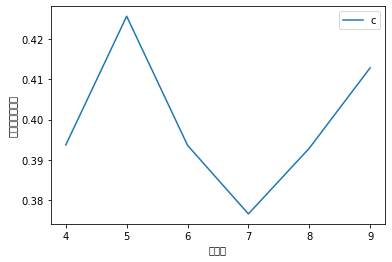

In [50]:
# Show graph
limit=10; start=4; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")  # 主题数
plt.ylabel("Coherence score") #  主题连贯度得分
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
# Print these coherence scores
for m, cv in zip(x, coherence_values):
    print(" Num Topics =", m, "Coherence Value =", round(cv, 4))

 Num Topics = 4 Coherence Value = 0.3937
 Num Topics = 5 Coherence Value = 0.4257
 Num Topics = 6 Coherence Value = 0.3936
 Num Topics = 7 Coherence Value = 0.3765
 Num Topics = 8 Coherence Value = 0.3929
 Num Topics = 9 Coherence Value = 0.4129


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
model_list

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- model_list[n] 和texts = tokens_list_clean  n需要根据前面的图表调整，调整好后再执行下一步

In [53]:
def dominant_topic(ldamodel = model_list[0], corpus = corpus, texts = tokens_list, user_id_str = user_id_str_list, date = date_list):
    # Create DF
    thread_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each thread
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                thread_topics_df = thread_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    thread_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    user_id_str = pd.Series(user_id_str)
    date = pd.Series(date)
    thread_topics_df = pd.concat([thread_topics_df, contents, user_id_str, date], axis=1)
    return thread_topics_df 

df_topic_thread_keywords = dominant_topic(ldamodel = model_list[1], corpus = corpus, texts = data_sam, user_id_str = user_id_str_list, date = date_list)

# Format
df_dominant_topic = df_topic_thread_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'User_id_str', 'date']

# Show
df_dominant_topic

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,User_id_str,date
0,0,0.0,0.8143,"汚染, トリチウム, 福島, 問題, 放射, 物質, 東電, 含む, 海洋, タンク",@daitojimari@agorajapan韓国は最後までゴミの海洋投棄をしていた国です。...,1168352626754195456,2019-09-10
1,1,3.0,0.4636,"大阪, 福島, 放出, 湾, 市長, 松井, 環境, 相, 汚染, 発言",引用&gt;「地球上には原発を運営する国が少なくないが、他国と他民族の生存まで脅かして核の廃...,548389275,2019-09-10
2,2,0.0,0.5810,"汚染, トリチウム, 福島, 問題, 放射, 物質, 東電, 含む, 海洋, タンク",谷口智彦さんは日経BPの経済記者出身で民間登用から外務省報道官に。安倍内閣の施政方針演説のほ...,64267271,2019-09-10
3,3,2.0,0.5614,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",#逆ギレ報復https://t.co/wfAslHkcaA韓国紙2019/09/06福島原発...,1010282833355501568,2019-09-10
4,4,3.0,0.3783,"大阪, 福島, 放出, 湾, 市長, 松井, 環境, 相, 汚染, 発言",あったあった。さっきの汚染水を海洋放水てのに絡んで。せっかく新技術開発されたのに。コレやらず...,4271455061,2019-09-10
...,...,...,...,...,...,...,...
13920,13920,3.0,0.4880,"大阪, 福島, 放出, 湾, 市長, 松井, 環境, 相, 汚染, 発言",放出するのは、あくまで法で定められた濃度以下の処理水。現在保管されている水をそのまま流すので...,126533936,2019-09-21
13921,13921,2.0,0.6618,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",文政権が“嫌がらせ”展開か「放射能五輪は危険」原発処理水に難くせも…韓国はすでに「日本の６倍...,112551613,2019-09-21
13922,13922,4.0,0.6974,"小泉, 進, 次郎, 大臣, 環境, 汚染, 発言, 相, 意気込む, 勉強_不足",【大前研一のニュース時評】進次郎氏の“無責任”発言は議論を遅らせる原発処理水の「海洋放出」は...,68643433,2019-09-21
13923,13923,2.0,0.2615,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",09/2108:44日テレウェークアップ！ぷらす韓国ＩＡＥＡに現地調査要請・小泉環境相「地元...,624214070,2019-09-21


In [54]:
df_topic_type_all = df_dominant_topic.join(df_type.set_index("user_id_str"), on = "User_id_str", how = "inner", sort = False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
df_topic_type_all.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,User_id_str,date,media,political elite,other,public
0,0,0.0,0.8143,"汚染, トリチウム, 福島, 問題, 放射, 物質, 東電, 含む, 海洋, タンク",@daitojimari@agorajapan韓国は最後までゴミの海洋投棄をしていた国です。...,1168352626754195456,2019-09-10,0,0,0,1
2621,2621,2.0,0.4467,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",@ktn1983今は韓国の福島第一原発の汚染水問題を勢いつかせることになると思います。韓国は...,1168352626754195456,2019-09-13,0,0,0,1
2912,2912,3.0,0.3684,"大阪, 福島, 放出, 湾, 市長, 松井, 環境, 相, 汚染, 発言",@JXENJ5oxd9RTIug福島第一原発の汚染水なら放出は可能ですけど、ストーカーの南朝...,1168352626754195456,2019-09-13,0,0,0,1
1,1,3.0,0.4636,"大阪, 福島, 放出, 湾, 市長, 松井, 環境, 相, 汚染, 発言",引用&gt;「地球上には原発を運営する国が少なくないが、他国と他民族の生存まで脅かして核の廃...,548389275,2019-09-10,0,0,0,1
2,2,0.0,0.5810,"汚染, トリチウム, 福島, 問題, 放射, 物質, 東電, 含む, 海洋, タンク",谷口智彦さんは日経BPの経済記者出身で民間登用から外務省報道官に。安倍内閣の施政方針演説のほ...,64267271,2019-09-10,0,0,0,1


In [56]:
time_2019

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['2019-09-10',
 '2019-09-11',
 '2019-09-12',
 '2019-09-13',
 '2019-09-14',
 '2019-09-15',
 '2019-09-16',
 '2019-09-17',
 '2019-09-18',
 '2019-09-19',
 '2019-09-20',
 '2019-09-21']

In [57]:
T1 = time_2019[:6]
T2 = time_2019[6:]
T1, T2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(['2019-09-10',
  '2019-09-11',
  '2019-09-12',
  '2019-09-13',
  '2019-09-14',
  '2019-09-15'],
 ['2019-09-16',
  '2019-09-17',
  '2019-09-18',
  '2019-09-19',
  '2019-09-20',
  '2019-09-21'])

In [59]:
df_topic_type_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13925 entries, 0 to 13916
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Document_No         13925 non-null  int64  
 1   Dominant_Topic      13925 non-null  float64
 2   Topic_Perc_Contrib  13925 non-null  float64
 3   Keywords            13925 non-null  object 
 4   Text                13925 non-null  object 
 5   User_id_str         13925 non-null  int64  
 6   date                13925 non-null  object 
 7   media               13925 non-null  object 
 8   political elite     13925 non-null  object 
 9   other               13925 non-null  object 
 10  public              13925 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1.3+ MB


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
df_topic_type = df_topic_type_all.query("Dominant_Topic == 2").query("other == 1")
df_topic_type = df_topic_type.sort_values(by = "date")
df_topic_type

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,User_id_str,date,media,political elite,other,public
12966,12966,2.0,0.4230,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",ソウル聯合ニュース◆福島原発の汚染水処理問題「まだ決まってない」＝韓国外交部https://...,57184966,2019-09-10,0,0,1,0
13002,13002,2.0,0.3829,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",&gt;日本環境相「福島原発汚染水、海に放出するしか方法がない」中央日報福島第一のトリチウム...,3177660174,2019-09-10,0,0,1,0
13691,13691,2.0,0.3276,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",汚染水の処理など原発対応で踏み絵を踏ませるのか。それとも、小泉氏が解決に向けて自信を示したの...,541345665,2019-09-10,0,0,1,0
13027,13027,2.0,0.3373,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",原田前環境相が「原発の汚染水を海に放出するしかない」と言ったこと。昨夜BBCは大きく報道して...,2924898150,2019-09-11,0,0,1,0
13017,13017,2.0,0.4550,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",日本のメディア･マスコミは「安倍自民党内閣の恫喝･情報統制」により報道しない何故なら福島原発...,723117293631205378,2019-09-11,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
13642,13642,2.0,0.7916,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",【韓国発狂】産経が、『韓国、原発汚染水・旭日旗を第三者に“告げ口”』と暴言:かたすみ速報ht...,3067777777,2019-09-21,0,0,1,0
13924,13924,2.0,0.3114,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",【祈祷師】音喜多駿は「情緒的な表現をすれば、福島原発の処理水に残っているのは、毒や有害成分で...,106258698,2019-09-21,0,0,1,0
13914,13914,2.0,0.3078,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",9/2108:44日テレウェークアップ！ぷらす韓国IAEAに現地調査要請・小泉環境相「地元傷...,624214070,2019-09-21,0,0,1,0
13923,13923,2.0,0.2615,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",09/2108:44日テレウェークアップ！ぷらす韓国ＩＡＥＡに現地調査要請・小泉環境相「地元...,624214070,2019-09-21,0,0,1,0


In [84]:
dict = {}
for i, d in df_sam.query("other == 1").iterrows():
    dict[d.user_id_str] = d.user_name

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
dict

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{144812834: 'karrento',
 70244743: 'hideinu',
 10462562: '47news',
 2383663554: 'shiratama_ji',
 451468218: 'sakura0319mluna',
 25080638: 'azukiglg',
 900868478227275778: 'kazu10233147',
 957932062224261127: 'Hiromi19611',
 1125077030385491969: 'shin_shr190506',
 57184966: 'gloomynews',
 461999811: 'syouwaoyaji',
 60831140: 'GreenpeaceJP',
 4602250512: 'hontounokotoga1',
 1445594592: 'RedGolgo',
 187454629: 'miakiza20100906',
 544012988: 'simanekomama',
 120675466: 'suhamayuki',
 265402759: 'GeorgeBowWow',
 620973639: 'MCANjp',
 3067777777: 'nonbeiyasu',
 106692904: 'kou_1970',
 569200130: 'kannamitsuta',
 144395772: 'kinoryuichi',
 269125621: 'Happy11311',
 365379554: 'aokiaoki1111',
 94120026: 'naoyafujiwara',
 409255813: 'photon2039v2',
 240698532: 'ishiitakaaki',
 68571425: 'hamemen',
 1149533721231388678: 'PeachTjapan2',
 154413370: 'kero_jiji',
 234781762: 'ombon8',
 354442287: 'xo749100naniha',
 57653827: 'Yamakawakenichi',
 120401094: 'uchida_kawasaki',
 273502947: 'harada_hiro

In [78]:
df_topic_type1 = df_topic_type_all.query("Dominant_Topic == 2").query("media == 1")
df_topic_type1 = df_topic_type.sort_values(by = "date")
df_topic_type1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,User_id_str,date,media,political elite,other,public
13760,13760,2.0,0.5990,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",イランと米、核合意で応酬＝韓国、原発処理水で注意喚起－ＩＡＥＡ総会https://t.co/...,143383314,2019-09-16,1,0,0,0
13764,13764,2.0,0.7451,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",「世界の海に影響」「根拠ない」＝韓国と日本、原発処理水で激論－ＩＡＥＡhttps://t.c...,143383314,2019-09-16,1,0,0,0
13763,13763,2.0,0.7259,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",韓国「原発汚染水は国際問題」ＩＡＥＡ総会で日韓応酬https://t.co/17yV2ruOQj,42816371,2019-09-16,1,0,0,0
13770,13770,2.0,0.4527,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",16日にウィーンで開かれた国際原子力機関（IAEA）年次総会で、東京電力福島第１原発から出る...,1003919790862286848,2019-09-16,1,0,0,0
13765,13765,2.0,0.4442,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",韓国、福島原発「汚染水」に懸念表明https://t.co/o4wV0vtlPK#tbs#t...,154415900,2019-09-16,1,0,0,0
13766,13766,2.0,0.7259,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",韓国「原発汚染水は国際問題」ＩＡＥＡ総会で日韓応酬：朝日新聞デジタルhttps://t.co...,112690339,2019-09-16,1,0,0,0
13767,13767,2.0,0.4909,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",「（福島第1原発の）汚染水問題は未解決で、世界中で恐怖と不安が増大している」と韓国。「事実に...,169480493,2019-09-16,1,0,0,0
13813,13813,2.0,0.5797,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",菅義偉官房長官は記者会見で、韓国政府がIAEA年次総会で福島第1原発の処理水を海に流せば「世...,143383314,2019-09-17,1,0,0,0
13780,13780,2.0,0.7258,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",韓国「原発汚染水は国際問題」ＩＡＥＡ総会で日韓応酬https://t.co/EzEuY6QiEm,145563033,2019-09-17,1,0,0,0
13776,13776,2.0,0.5271,"韓国, 日本, 流す, 世界, 汚染, 科学, 海, 倍, 放出, 問題",【原発処理水、韓国がＩＡＥＡで懸念表明】韓国の科学技術情報通信省の第１次官は「もはや日本の国...,562773398,2019-09-17,1,0,0,0


In [82]:
# 意见领袖
for i, d in df_topic_type.iterrows():
    print(d.date, "\n", d.Text)

2019-09-10 
 ソウル聯合ニュース◆福島原発の汚染水処理問題「まだ決まってない」＝韓国外交部https://t.co/McXFAdWmmx「韓国政府は日本側に対し、汚染水の放出問題に関する情報共有を要請する口述書（外交文書）を送り、国際的な協力を求める文書を国際原子力機関（ＩＡＥＡ）に提出している」
2019-09-10 
 &gt;日本環境相「福島原発汚染水、海に放出するしか方法がない」中央日報福島第一のトリチウム水にイチャモンをつける韓国は、その8倍以上のトリチウムを日本海に放出している事実小泉進次郎新大はイチャモン国家に言葉尻取られないようにしっかり発言してほしいhttps://t.co/8NUht0TwhO
2019-09-10 
 汚染水の処理など原発対応で踏み絵を踏ませるのか。それとも、小泉氏が解決に向けて自信を示したのか。何れにしても問題解決に向けた前進を望むしかない。
2019-09-11 
 原田前環境相が「原発の汚染水を海に放出するしかない」と言ったこと。昨夜BBCは大きく報道していた。世界で孤立化する日本だがさらに評価を下げ、孤立化が進展するだろう。原発事故の放射能汚染問題、日本人が考えるよりも外国ではずっと危険視されている。日本の海産物に深刻な影響が出るだろう。😩
2019-09-11 
 日本のメディア･マスコミは「安倍自民党内閣の恫喝･情報統制」により報道しない何故なら福島原発事故の「真犯人が安倍晋三」だから海外メディアは実態を正直に暴露している、何も隠す必要も無いので参考Youtube検索:「放射能汚染水」
2019-09-11 
 四面楚歌の韓国が持ち出す必殺技「福島第一原発の汚染水情報公開要請」で日本は窮地に＝今市太郎|マネーボイスhttps://t.co/618l4hAf1W
2019-09-12 
 ,2020東京五輪ピック原発汚染水と旭日旗で安倍総理はお♥も♥て♥な♥しhttps://t.co/z41q2ziUlB
2019-09-12 
 【韓国も高濃度の処理水を海に放出してるのに】日本が原発処理水を海に放出？韓国が黙っていなかった:かたすみ速報https://t.co/we6EkDPQaT
2019-09-13 
 この問題も旭日旗の問題も韓国から抗議されたからと言って強行すれば、それこそ日本が世界から爪弾きにな

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
# 传统媒体
for i, d in df_topic_type1.iterrows():
    print(d.date, "\n", d.Text)

2019-09-16 
 イランと米、核合意で応酬＝韓国、原発処理水で注意喚起－ＩＡＥＡ総会https://t.co/FlFkW41hKT
2019-09-16 
 「世界の海に影響」「根拠ない」＝韓国と日本、原発処理水で激論－ＩＡＥＡhttps://t.co/MspLGl20V2
2019-09-16 
 韓国「原発汚染水は国際問題」ＩＡＥＡ総会で日韓応酬https://t.co/17yV2ruOQj
2019-09-16 
 16日にウィーンで開かれた国際原子力機関（IAEA）年次総会で、東京電力福島第１原発から出る放射性物質を含む処理水をめぐり、海に放出されれば「世界の海洋環境に影響する」と主張する韓国と、「科学的根拠がない」と反発する日本が、異例の激論を繰り広げました。https://t.co/SOmyFKxzhp
2019-09-16 
 韓国、福島原発「汚染水」に懸念表明https://t.co/o4wV0vtlPK#tbs#tbsnews#japan#news
2019-09-16 
 韓国「原発汚染水は国際問題」ＩＡＥＡ総会で日韓応酬：朝日新聞デジタルhttps://t.co/BNedMQSRDR
2019-09-16 
 「（福島第1原発の）汚染水問題は未解決で、世界中で恐怖と不安が増大している」と韓国。「事実に基づいておらず、全く受け入れられない」と日本。国際原子力機関（IAEA）の総会で日韓が応酬を繰り広げました。https://t.co/9aSCPUJfoz
2019-09-17 
 菅義偉官房長官は記者会見で、韓国政府がIAEA年次総会で福島第1原発の処理水を海に流せば「世界の海洋環境に影響する」と主張したことについて「事実関係および科学的根拠に基づかず、わが国に対するいわれのない風評被害を及ぼしかねないもので極めて遺憾だ」と述べました。https://t.co/fuBZOgO3I6
2019-09-17 
 韓国「原発汚染水は国際問題」ＩＡＥＡ総会で日韓応酬https://t.co/EzEuY6QiEm
2019-09-17 
 【原発処理水、韓国がＩＡＥＡで懸念表明】韓国の科学技術情報通信省の第１次官は「もはや日本の国内問題ではなく、世界全体の海洋環境に影響を及ぼしうる重大な国際問題となる」と強調しました。https://t.co/72

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#df_topic_type = df_topic_type_all.query('date in @T2')

In [200]:
#df_time1 = df_topic_type[["Document_No", "Dominant_Topic", "media", "political elite", "other", "public"]]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [201]:
#df_time1.to_csv("df_time1.csv", index = False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [210]:
# media
df_topic_type[df_topic_type["media"] == 1].Dominant_Topic.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.0    43
2.0    16
0.0    11
1.0     6
4.0     5
Name: Dominant_Topic, dtype: int64

In [211]:
# political elite
df_topic_type[df_topic_type["political elite"] == 1].Dominant_Topic.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.0    17
0.0    16
1.0     4
2.0     3
4.0     1
Name: Dominant_Topic, dtype: int64

In [212]:
# 自媒体
df_topic_type[df_topic_type["other"] == 1].Dominant_Topic.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    179
3.0    178
2.0    100
1.0     54
4.0     47
Name: Dominant_Topic, dtype: int64

In [213]:
# public
df_topic_type[df_topic_type["public"] == "1"].Dominant_Topic.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.0    3922
2.0    1974
0.0    1420
1.0     883
4.0     658
Name: Dominant_Topic, dtype: int64

In [206]:
df_dominant_topic.Dominant_Topic.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.0    6257
2.0    2412
0.0    2242
4.0    1568
1.0    1446
Name: Dominant_Topic, dtype: int64

In [207]:
#df_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 0.0].reset_index(drop = True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 トリチウム等放射性物质
1 对于海洋排放的反对态度
2 韩国反应
3 大阪湾问题
4 小泉进次郎道歉事件

In [225]:
# 抽取千分之五条：13925*千分之五 = 69.625
np.random.seed(42)
df_topic_type = df_topic_type_all.sample(70)
df_topic_type.reset_index(drop = True, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [240]:
#with open("manual_code_stage1_predict.csv", "w", encoding = "utf-8") as f:
    #for i, d in df_topic_type.iterrows():
        #csvw = csv.writer(f)
        #csvw.writerow([d.Text, d.Dominant_Topic, d.Keywords])
        #f.write([d.Text, d.Dominant_Topic, d.Keywords])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
